<a href="https://www.kaggle.com/code/pradungroek/financial-sentiment-analysis?scriptVersionId=101003886" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Financial Sentiment Analysis
#### Datasets(FiQA, Financial PhraseBank)

---

### CRISP-DM process step
- ##### 1. Data Understanding
- ##### 2. Preprocessing
- ##### 3. Exploration
- ##### 4. Modelling
- ##### 5. Evaluation
##### Note : TH version
---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-sentiment-analysis/data.csv


In [2]:
original_df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')

---
## **Data Understanding**

In [3]:
def understand(data):
    
    display(data.head())
    print(data.shape)
    display(data.describe())
    print(data.info())
    print(data.isnull().sum())
    print(data['Sentiment'].unique())
    
understand(original_df)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


(5842, 2)


,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None
Sentence     0
Sentiment    0
dtype: int64
['positive' 'negative' 'neutral']


 - ข้อมูลชุดนี้มีบทความทั้งหมด 5,842 บทความแบ่งเป็น 3 ระดับอารมณ์คือ ด้านบวก,เป็นกลางและด้านลบ
 - ด้านบวก(Positive) พบมากที่สุด
 
**Note:** สิ่งที่ต้องพิจารณาต่อคือข้อมูลใน Class label สมดุลกันหรือไม่ ซึ่งส่งผลต่อประสิทธิภาพโมเดลโดยตรง  

#### Matplotlib
 - แสดงสัดส่วนของคลาสเป้าหมายออกมาเพื่อเห็นภาพง่ายขึ้น

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,8

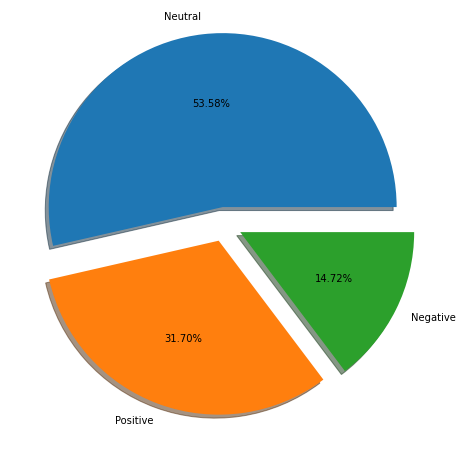

In [5]:
plt.pie(original_df.Sentiment.value_counts()/len(original_df),
        labels =['Neutral','Positive','Negative'],
        autopct='%1.2f%%',shadow=True,explode=(0.1, 0.1, 0.1))

plt.show()

**Pie Chart**
แสดงสัดส่วนพบว่าเกินครึ่งถึง 53.58% เป็นกลางและ 14.72% เป็นข้อความเชิงลบ \
ดังนั้นมีโอกาสที่โมเดลอาจไม่มีประสิทธิภาพเพียงพอในการจำแนกบทความที่บอกอารมณ์ตลาดด้านลบ 

---
## **Preprocessing**

- ตรวจจับภาษาเขียนในบทความ (Language detection)

In [6]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=1a0dc28904189ee831bb6d49466e3e5bc35f9788b3fc82aaf98859de9ca3df53
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [7]:
from langdetect import detect_langs

sentence = list(original_df.Sentence)
languages = []

for i in range(len(sentence)):
    languages.append(detect_langs(sentence[i]))
    
print('The detected languages are: ', languages[:3])

The detected languages are:  [[en:0.99999540162259], [en:0.9999959523752826], [en:0.9999958595894365]]


In [8]:
languages = [str(lang).split(':')[0][1:] for lang in languages]
original_df['language'] = languages

display(original_df.language.describe())
display(original_df['language'].value_counts())
display(original_df.head())

count     5842
unique      19
top         en
freq      5741
Name: language, dtype: object

en    5741
de      15
tl      15
ca      13
fr      12
da       9
no       7
it       6
nl       6
sv       4
et       3
so       3
af       2
cy       1
ro       1
vi       1
es       1
pt       1
pl       1
Name: language, dtype: int64

,Sentence,Sentiment,language
0,The GeoSolutions technology will leverage Bene...,positive,en
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,en
2,"For the last quarter of 2010 , Componenta 's n...",positive,en
3,According to the Finnish-Russian Chamber of Co...,neutral,en
4,The Swedish buyout firm has sold its remaining...,neutral,en


- พบว่าในชุดข้อมูลนี้มีทั้งหมด 19 ภาษาโดยภาษาอังกฤษพบมากที่สุดมีถึง 98% จากจำนวนบทความทั้งหมด
(5744/5842) = 0.9832
- ดังนั้นบทความที่องค์ประกอบหลักเป็นภาษาอื่นจะพิจารณาตัดออก

In [9]:
original_df2 = original_df.copy()
original_df2 = original_df2[original_df2['language'] =='en']
print(original_df2.shape)

(5741, 3)


#### **Cleaning Step**
- เริ่มจากตัดอักษรที่ไม่จำเป็นออกโดยใช้ Regular expression
- การตัดคำและลดรูปแบบการผันคำ Word tokenize and Stemming
- การจำกัดอักษรและตัดคำฟุ่มเฟือย Count and stopwords

In [10]:
from nltk import word_tokenize
import re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer

def text_clean1(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),' ',text)
    text = re.sub('\w*\d\w*','',text)
    text = re.sub('[''""...]','',text)
    text = re.sub('\n','',text)
    text = re.sub(r'\b\w{1,2}\b','',text)
    
    return text

clean1 = lambda x: text_clean1(x)
original_df2['clean1'] = pd.DataFrame(original_df2.Sentence.apply(clean1))

In [11]:
#Tokenize

tokens = [word_tokenize(review) for review in original_df2.clean1]
cleaned_tokens = [[word for word in item if word.isalpha()] for item in tokens]
original_df2['cleaned_sent'] = cleaned_tokens

#Stemming

WNlemmatizer = WordNetLemmatizer()

def stem(tokenized_text):
    text =" ".join([WNlemmatizer.lemmatize(word) for word in tokenized_text])
    return text

original_df2['stem_sent'] = original_df2['cleaned_sent'].apply(lambda x: stem(x))

### column 'clean1','cleaned_sent' สร้างมาเพื่อเช็คลำดับความเปลี่ยนแปลงของข้อความ

original_df2 = original_df2[original_df2['language'] =='en']
original_df2 = original_df2.drop(['Sentence','language','cleaned_sent','clean1'], axis=1)

### Column 'stem_sent' (sent ย่อมาจาก sentence)

In [12]:
import itertools
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#รวมคำประเภท Stop word จาก 3 library
stop_words = set(stopwords.words('english'))

if __name__ == '__main__':
    
    custom_stop_words = set(itertools.chain(stop_words, STOPWORDS, ENGLISH_STOP_WORDS))
    
####

original_df2['sw_sent'] = original_df2['stem_sent'].apply(
    
    lambda x: ' '.join([word for word in x.split() if word not in (custom_stop_words)])
)

In [13]:
# Count character
tokens_sw = [word_tokenize(review) for review in original_df2.sw_sent]
sw_tokens = [[word for word in item if len(word) > 2] for item in tokens_sw]

display(original_df2.head()) ### ตรวจสอบถึงการเปลี่ยนแปลง
original_df2 = original_df2.drop(['stem_sent'],axis=1)

,Sentiment,stem_sent,sw_sent
0,positive,the geosolutions technology will leverage bene...,geosolutions technology leverage benefon gps s...
1,negative,esi low down real possibility,esi low real possibility
2,positive,for the last quarter componenta net sale doubl...,quarter componenta net sale doubled period yea...
3,neutral,according the finnish russian chamber commerce...,according finnish russian chamber commerce maj...
4,neutral,the swedish buyout firm ha sold it remaining p...,swedish buyout firm ha sold remaining percent ...


In [14]:
### แปลง list of list เป็น list of string เตรียมไว้สำหรับการสำรวจข้อมูลต่อไป

last_token = list(itertools.chain(*sw_tokens))  

**Note:**
- ถึงขั้นตอนนี้จะได้ **original_df2** ที่มีคอลัมน์ **'sw_sent'** คือเป็นบทความที่ผ่านการทำความสะอาดแล้ว
- **last_token** คือ word token ที่มีการกรองตัวอักษรมากกว่า 2 ขึ้นไป
---

### Exploration

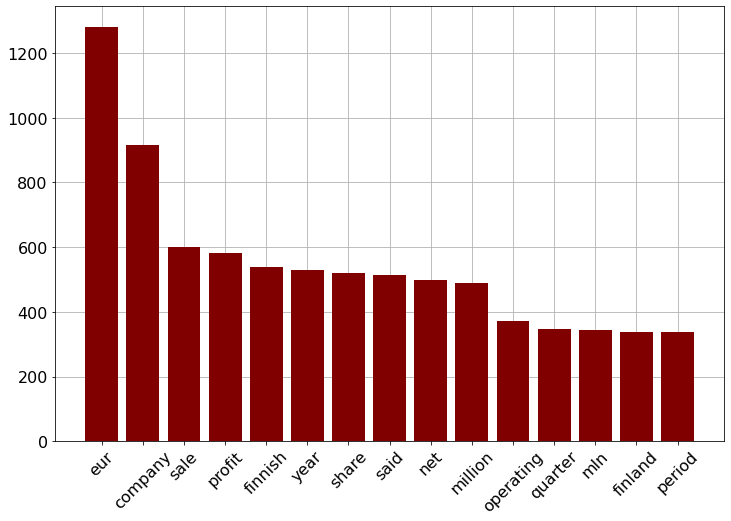

In [15]:
# การนับคำ (Bag of word)

bow_simple = Counter(last_token).most_common(15) ### แสดง 15 คำที่พบบ่อยในบทความทั้งหมดของชุดข้อมูลมูล

labels = [item[0] for item in bow_simple]
number = [item[1] for item in bow_simple]
nbars = len(bow_simple)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### **Analysis**
- มีการพูดถึงสกุลเงิน EUR มากที่สุด
- mln เป็นคำย่อที่มีหลายความหมายเช่น เป็นระบบหนึ่งในการขับเคลื่อนโทเค็นอีเธอร์เรียม, หรือจะเป็นกองทุน VanEck ในอเมริกาก็ได้\
ดังนั้นต้องตรวจสอบถ้าไม่ใช่คำเฉพาะก็ต้องดำเนินการตัดทิ้ง
- พูดถึงประทศ Finland เกือบ 400 ครั้งในข้อมูลชุดนี้ (จึงแอบสงสัยเองว่าเกิดอะไรขึ้น)

In [16]:
### ตรวจสอบคำ mln จาก original dataset เพื่อทำความเข้าใจบทความตัวอย่างได้ง่ายขึ้น

mln_df = original_df[original_df['Sentence'].str.contains('mln')]
print(mln_df['Sentence'][:3].tolist(),end='\n\n')

finland_df = original_df[original_df['Sentence'].str.contains('Finland')]
print(finland_df['Sentence'][:3].tolist(), end='\n\n')
print(finland_df['Sentiment'].value_counts())

['The firm generated sales of 187 mln eur in 2005 .', 'Dealers said the share was largely hit by investor disappointment about a refining margin of just 9.48 usd per barrel for the quarter and the performance of its shipping unit , which saw EBIT drop to 5 mln eur from 20 mln eur a year amid a fall in volumes and tanker rates .', 'Rapala said it estimates it will make savings of 1-2 mln eur a year by centralising its French operations at one site .']

['According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .', 'The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .', 'Circulation revenue has increased by 5 % in Finland and 4 % in Sweden in 2008 .']

neutral     221
positive     64
negative     34
Name: Sentiment, dtype: int64


**ผลลัพท์การตรวจสอบ**
- mln คือคำย่อ million สามารถ update ตัดคำได้ออกได้เลย
- บทความที่พูดถึงประเทศฟินแลนด์ ค่อนข้างเป็นไปในทางบวกและกล่าวถึงการลงทุนในอุตสาหกรรมของประเทศ


In [17]:
###ย้อนกระบวนการ preprocessing เพื่อ update stopword 

new_stop = {"mln"}

def update_stop(new_stop):
    custom_stop_words.update(new_stop)
    
update_stop(new_stop)

In [18]:
### เริ่มกระบวนการ stop word และใช้ def ที่สร้างขึ้น apply ใหม่อีกครั้ง

def re_stopword(data,col):
    
    custom_stop_words.update(new_stop)
    original_df2[col] = original_df2[col].apply(
        
        lambda x: ' '.join([word for word in x.split() if word not in (custom_stop_words)]))
    
    original_df2[col] = pd.DataFrame(original_df2[col].apply(clean1))
    
re_stopword(original_df2,'sw_sent')

##### **Note:**
- ถึงตรงนี้ได้ Def update_stop กับ re_stopword ซึ่งใช่สำหรับ try and error สำหรับการปรับปรุงคำให้เหมาะสมกับลักษณะงานอื่นๆ

In [19]:
new_stop = {"mln","finnish","company","year","operating","profit"}
update_stop(new_stop)

#### **Word Cloud**
- จุดมุ่งหมายเพื่อเห็นภาพของบทความในแต่ละสภาพอารมณ์ (Sentiment) และตรวจสอบคำอื่นๆ ที่อาจไม่จำเป็นออกไป

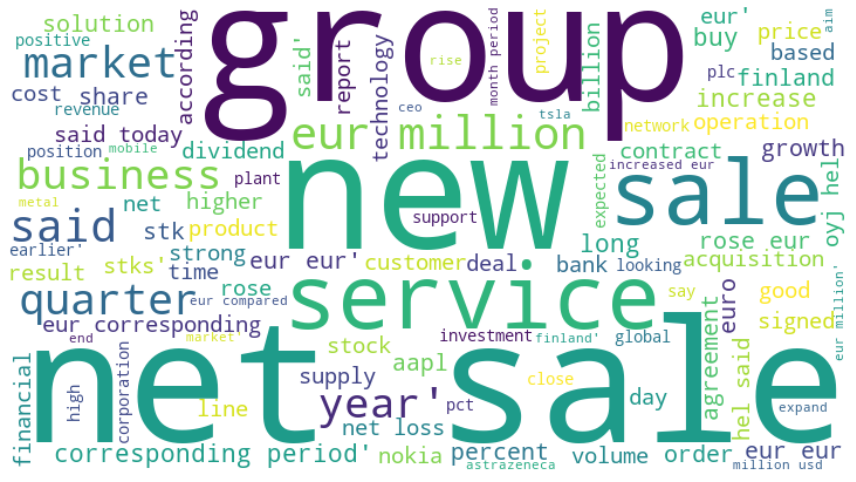

In [20]:
from wordcloud import WordCloud

def plot_cloud(text,collor):
    
    wordcloud_sent2 = WordCloud(stopwords=custom_stop_words,background_color= collor,
                                max_words=100,width=720,height=400,
                                random_state=42).generate(str(text))
    
    plt.imshow(wordcloud_sent2, interpolation='bilinear') 
    plt.axis("off")
    plt.tight_layout() 
    plt.show()

plot_cloud(list(original_df2[original_df2['Sentiment'] == 'positive'].sw_sent),'white')

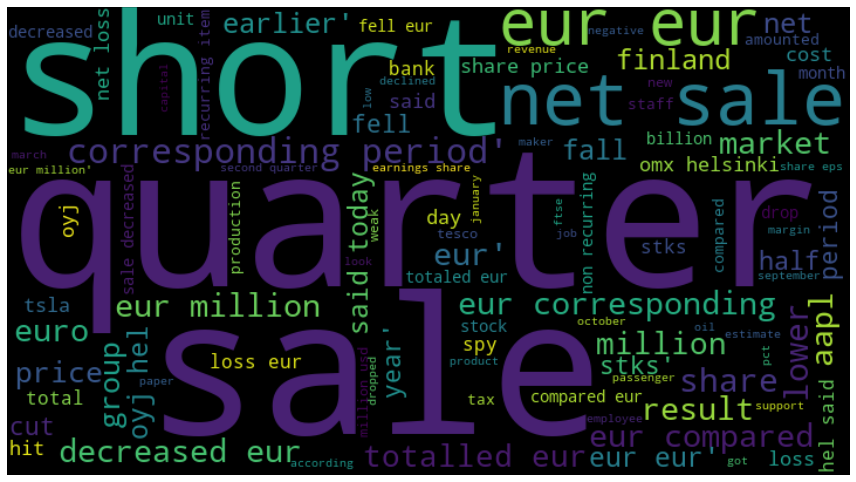

In [21]:
plot_cloud(list(original_df2[original_df2['Sentiment'] == 'negative'].sw_sent),'black')

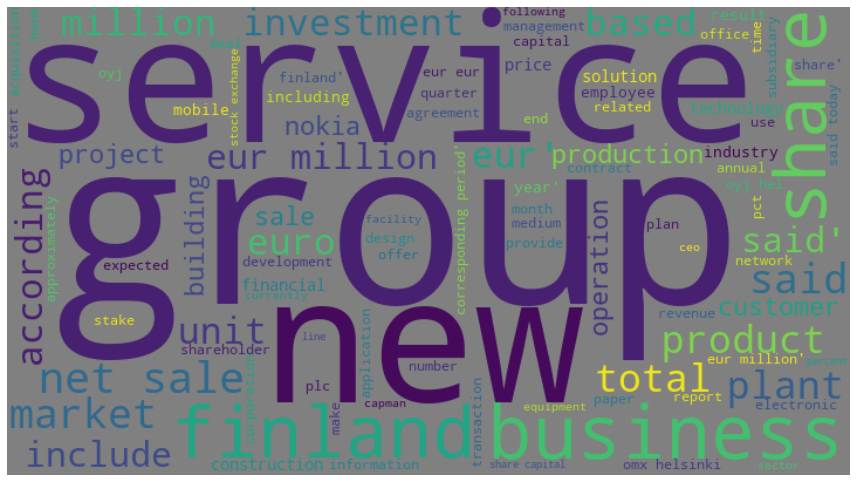

In [22]:
plot_cloud(list(original_df2[original_df2['Sentiment'] == 'neutral'].sw_sent),'grey')

***ผลลัพท์***
- สำหรับบทความเชิงลบมักจะมีคำว่า Short เป็นคำที่สังเกตได้ง่าย
- สำหรับบทความเชิงบวก

In [23]:
re_stopword(original_df2,'sw_sent')  ### update stopword ใน dataset

 #### **TextBlob**
 - **สำรวจทิศทางและความเห็นของข้อความในบทความ (Polarity and Subjectivity)** \
 เป็นส่วนหนึ่งในการสร้างคุณลักษณะข้อมูล (Feature) สำหรับทำโมเดล
 - **Polarity** คือทิศทางของบทความจากคำที่มีอิทธิพลต่อสภาวะอารมณ์
 - **Subjectivity** คือ บทความนั้นเป็นคำที่เป็นความเห็นหรือวิจารณญาณส่วนตัวมากน้อยแค่ไหน

In [24]:
from textblob import TextBlob   

sentence = list(original_df2.sw_sent)
blob_sent = []

for i in range(len(sentence)):
    blob_sent.append(TextBlob(sentence[i]).sentiment)

blob_val = [re.split(r'[=, )]',str(lang))[1::3] for lang in blob_sent]
original_df2[['Polarity','Subjectivity']] = blob_val

col = ['Polarity','Subjectivity']
for col in col:
    original_df2[col] = original_df2[col].astype('float').round(4)
    
display(original_df2.head())
display(original_df2['sw_sent'][:1].tolist())

,Sentiment,sw_sent,Polarity,Subjectivity
0,positive,geosolutions technology leverage benefon gps s...,0.2091,0.5886
1,negative,esi low real possibility,0.1000,0.3000
2,positive,quarter componenta net sale doubled period ear...,0.0000,0.2500
3,neutral,according russian chamber commerce major const...,0.0312,0.2500
4,neutral,swedish buyout firm sold remaining percent sta...,-0.1000,0.2333


['geosolutions technology leverage benefon gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model']

การนับจำนวนคำในบทความ (len word)

In [25]:
len_tokens = []
tokens_original = [word_tokenize(review) for review in original_df2.sw_sent] 
for i in range(len(tokens_original)):
     len_tokens.append(len(tokens_original[i]))
        
original_df2['n_words'] = len_tokens

**TfidfVectorizer**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
def tfidf(data):
    vect = TfidfVectorizer(ngram_range=(1,2) ,min_df=10, max_features=5000,)
    vect.fit(data.sw_sent)
    X_review = vect.transform(data.sw_sent)
    X_tfidf = pd.DataFrame(X_review.toarray(), columns=vect.get_feature_names())
    
    return X_tfidf

X_tfidf = tfidf(original_df2)
feature = original_df2[['Sentiment','Polarity', 'Subjectivity', 'n_words']]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
X_tfidf.shape

(5741, 1303)

In [29]:
def concat(word_tfidf,feature):
    feature.index = word_tfidf.index
    final_dataset1 = pd.concat([word_tfidf,feature],axis=1)
    
    return final_dataset1

final_dataset1 = concat(X_tfidf,feature)

***Note:***
- **final_dataset1** ที่ประกอบด้วย X_tfidf และ feature 
- **X_tfidf** คือ ค่าน้ำหนักของคำในบทความเทียบกับบทความในชุดข้อมูลทั้งหมด
- **feature** คือ คุณลักษณะข้อมูลของบทความนั้นๆ


#### Class label
> คลาสเป้าหมายที่ต้องการจำแนกคือ **Sentiment**

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
final_dataset1['Sentiment'] = encoder.fit_transform(final_dataset1['Sentiment'])

encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

## Modelling
- **LogisticRegression** เป็นโมเดลเริ่มต้นเนื่องจากการคำนวณไม่ซับซ้อนและประหยัดทรัพยากรเวลาในการประมวลผล


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

##### **แบ่งชุดข้อมูลสำหรับเทรนและเทส**
- กำหนดอัตราส่วนไว้ที่ 80:20

In [32]:
y = final_dataset1.Sentiment
X = final_dataset1.drop('Sentiment', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### LogisticRegression

> **LogisticRegression** คือ การวิเคราะห์ถดถอยแบบโลจิสติคใช้สำหรับข้อมูลสถิติเชิงคุณภาพ\
โดยเริ่มต้นกำหนดค่าจำนวนการวนซ้ำ (max_iter) ในการแก้ไขปัญหาของ Machine และ\
อัลกอริทึมที่ใช้แบบ lbdgs เป็นการประมาณค่าเมทริกซ์อนุพันธ์อันดับสอง ข้อดีคือประหยัด ram

In [33]:
log_reg = LogisticRegression(max_iter=1000,random_state=66,solver="lbfgs")

In [34]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)

print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_predicted))

Accuracy on train set:  0.7804878048780488
Accuracy on test set:  0.6936466492602262


- ผลลัพท์พบว่าค่าความแม่นยำยังน้อยอยู่ สาเหตุส่วนหนึ่งเป็นเพราะความไม่สมดุลของคลาสเป้าหมาย\
เนื่องจากเราทราบอยู่แล้วว่า Clsss neutral มีมากกว่า 53.58% แตกต่างกับ negativeอยู่ที่ 14.72%
- ดังนั้นเป้าหมายต่อไปคือการจัดการความไม่สมดุลนี้ ซึ่งเทคนิคมีหลายวิธีสำหรับโปรเจคนี้ทดสอบด้วยเทคนิคสุ่มข้อมูลแบบ Upsampling 


In [35]:
confusion = y_test.to_frame()
confusion['Pred_sentiment'] = y_predicted
confusion = confusion.replace([0,1,2],['negative', 'neutral', 'positive'])

confusion_matrix = pd.crosstab(confusion['Sentiment'], confusion['Pred_sentiment'],
                               rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  negative  neutral  positive
Actual                                
negative         34      102        26
neutral          22      534        52
positive         14      136       229


In [36]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, y_predicted, average='weighted')

(0.680550165508113, 0.6936466492602262, 0.6710677758731182, None)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


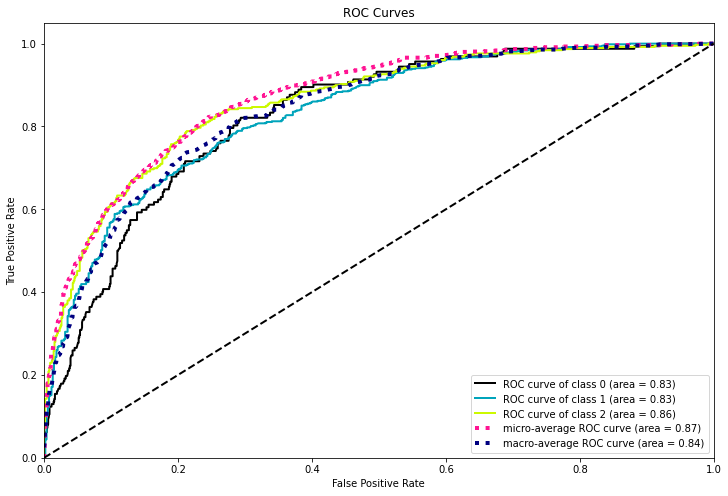

In [37]:
import scikitplot as skplt

y_probas = log_reg.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

---

##### Upsampling

In [38]:
from sklearn.utils import resample

df_neutral = original_df2[(original_df2['Sentiment']=='neutral')] 
df_negative = original_df2[(original_df2['Sentiment']=='negative')]
df_positive = original_df2[(original_df2['Sentiment']=='positive')]

df_negative_upsampled = resample(df_negative,replace=True,n_samples= 4000,random_state=42)  
df_positive_upsampled = resample(df_positive, replace=True,n_samples= 4000,random_state=42)

df_upsampled = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

##Thx Akshay Dev##

In [39]:
Upsampling_tfidf = tfidf(df_upsampled)
final_dataset2 = concat(Upsampling_tfidf,df_upsampled[['Sentiment','Polarity', 'Subjectivity', 'n_words']])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
y_up = final_dataset2.Sentiment
X_up = final_dataset2.drop('Sentiment', axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_up, y_up, test_size=0.2, random_state=42)

In [41]:
log_reg.fit(X_train2, y_train2)
y_predicted_up = log_reg.predict(X_test2)

print('Accuracy on train set: ', log_reg.score(X_train2, y_train2))
print('Accuracy on test set: ', accuracy_score(y_test2, y_predicted_up))

Accuracy on train set:  0.8841134113411341
Accuracy on test set:  0.8241115609536662


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


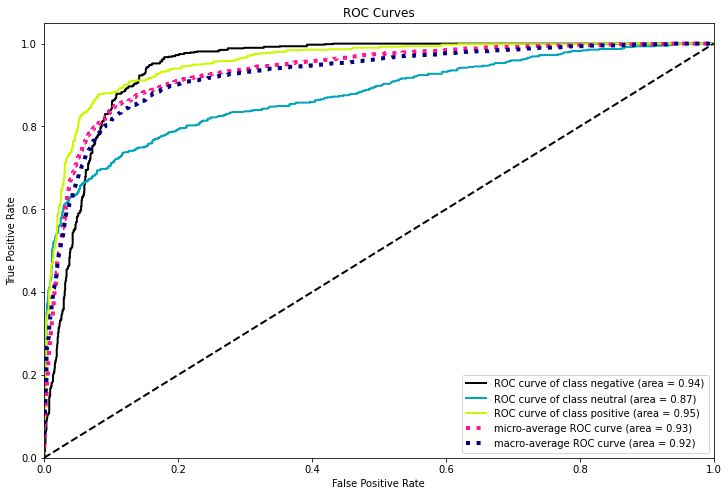

In [42]:
y_probas_up = log_reg.predict_proba(X_test2)
skplt.metrics.plot_roc_curve(y_test2, y_probas_up)
plt.show()

**ผลลัพท์** พบว่าค่าความแม่นยำของชุดข้อมูลทดสอบอยู่ที่ 0.82 หรือประมณ 82% ซึ่งถือว่าสูงกว่าเดิมพอสมควร\
อีกทั้งค่าความแม่นยำของในชุดข้อมูลเทรนออยู่ที่ประมาณ 88% ซึ่งแตกต่างกันน้อยลงเหลือ 6% ก่อนหน้าห่างกันอยู่ประมาณ 10%\
หมายความว่าโมเดลเริ่มออกจากจุดเหตุการณ์ overfit แล้ว
####
### **สรุป**
- โปรเจคนี้เป็นการสร้างโมเดลวิเคราะห์ข้อความเพื่อพยากรณ์สภาวะอารมณ์ของตลาดทางการเงิน ประโยชน์คือเป็นอีกเครื่องมือช่วยบอกแนวโน้ม-ทิศทางของตลาดในอนาคตได้ ตัวอย่างเช่น เมื่อมีบทความหรือบทวิเคราะห์ตลาดการเงินออกมาจำนวนมากแล้วโมเดลตรวจจับว่าเป็นบทความด้านลบมากกว่าด้านบวก แน่นอนบทความด้านลบย่อมมีอิทธิพลต่อจิตใจ-ความรู้สึกของผู้เล่นในตลาด ดังนั้นผู้ที่ทราบถึง Sentiment ที่รวดเร็วย่อมคว้าโอกาสทำกำไรได้มากกว่า

##### **ข้อเสนอแนะ**
- ในการปรับปรุง-พัณนาโมเดลสามารถต่อยอดไปได้อีกเช่น
- การทำ feature engineer สร้างคุณลักษณะข้อมูลใหม่ที่ส่งผลต่อโมเดลในการเรียนรู้
- เปลี่ยนเทคนิคการทำ Vector Creation จาก TF-IDF เป็น Binary, Term Occurrecnce, Term Frequency 
- เปลี่ยนเทคนิคการทำ Preprocessing เช่น stem porter, snowball , financial dictionary
- เปลี่ยนอัลกอริทึมการเรียนรู้ของเครื่องจักรเช่น 
> - SVM ซึ่งข้อดีคือให้ค่า performance สูงและ generalise ได้ดีคือโอกาสเกิด overfit น้อยรวมถึงอดทนต่อ noise
> - สลับไปใช้ Unsupervise laerning แต่ส่วนตัวมองว่าใช้ทักศิลปะ(Art)มากกว่า science เพราะถ้าบทความทั้งหมดที่นำมาเป็นข้อมูลมันไม่ได้มีแค่ 3 Segment ผลลัพท์การทำนายมันก็ไม่ค่อยถูกต้องนัก ทำให้การวิเคราะห์ segment ใหม่ต้องอาศัยวิธี Subjective เข้ามาร่วมด้วย (ใช้ Domain expert)


# **END**